# Titre du projet ( a décider)

In [60]:
## Sommaire

1. Number of games by genre.
2. Most played games.
3. Correlation between release date and ~reviews/plays.

## Introduction

Blabla

SyntaxError: invalid syntax (1943317614.py, line 3)

In [61]:
# Install dependencies

!pip install pandas matplotlib ipywidgets kaggle

1. Number of games by genre.

In [62]:
# Loading data
import os
import pandas as pd

file_path = "Datasets/Data/backloggd_games.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(df.shape) # row and columns
    print(df.columns) # name/index
    df.head() # Preview

else:
    print("The file does not exist. Check the path or place the file in the correct location")


(60000, 14)
Index(['Unnamed: 0', 'Title', 'Release_Date', 'Developers', 'Summary',
       'Platforms', 'Genres', 'Rating', 'Plays', 'Playing', 'Backlogs',
       'Wishlist', 'Lists', 'Reviews'],
      dtype='object')


In [63]:
# Remove missing values, convert to string, and clean characters like [], '
all_genres = df['Genres'].dropna().astype(str).str.replace(r'[\[\]\']', '', regex=True)

# Split genres by comma, explode into rows, and strip whitespace
all_genres = all_genres.str.split(',').explode().str.strip()


# We remove empty genres 
all_genres = all_genres[all_genres != ""]


In [64]:
# Counting occurrences
genre_counts = all_genres.value_counts()
print("Number of games by genre :\n", genre_counts.head(10))

Number of games by genre :
 Genres
Adventure    19368
Indie        16816
RPG           9234
Simulator     8050
Strategy      7766
Shooter       7258
Puzzle        6935
Platform      6126
Arcade        5603
Sport         3912
Name: count, dtype: int64


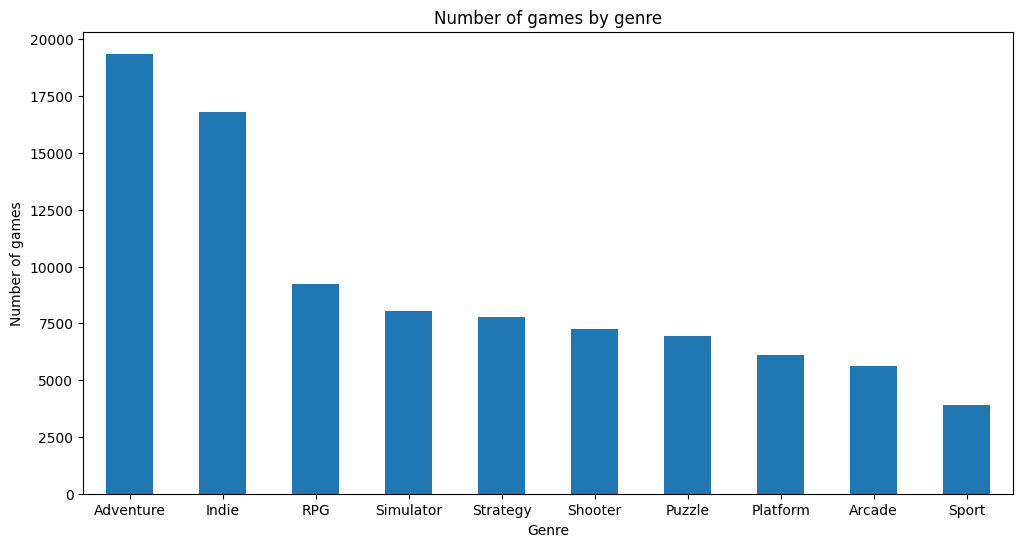

In [65]:
import matplotlib.pyplot as plt

# Graphical 
plt.figure(figsize=(12, 6))
genre_counts.head(10).plot(kind='bar')
plt.title("Number of games by genre")
plt.xlabel("Genre")
plt.ylabel("Number of games")
plt.xticks(rotation=0)
plt.show()
